## **Import Libraries**

In [ ]:
import math
import datetime
import numpy as np 
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# Dimensionality Reduction Methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Feature selection modules
from sklearn.feature_selection import mutual_info_classif,RFE,RFECV
from sklearn.feature_selection import mutual_info_regression

# Classification modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Regression modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor

# Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error, r2_score

# Split methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold as cross_valid_kfold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold  as cross_valid_stratified_kf
from sklearn.model_selection import StratifiedShuffleSplit

#Smote
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
seed=42

!pip install plotly
import plotly.graph_objs as plt_go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, plot, iplot

import warnings
warnings.filterwarnings('ignore')

## **Fetch Dataset**
>The dataset is downloaded from Kaggle and stored on github. It is a preprocessed and balanced version and can be used to accurately predict churners.

In [ ]:
get_ds = "https://raw.githubusercontent.com/Rumsha001/ML2/main/dataset/telecom_dataset.csv"

df = pd.read_csv(get_ds)
df.dropna(axis=0, inplace=True)
df

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,3399894,No,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,1.0,13.0,0.7,0.0,11.2,5.7,0.0,29.3,17.0,6.7,0.0,0.0,30,1,1,NEVELC619,1.0,1.0,883.0,48.0,48.0,Yes,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,No,No,0,4,No,0,Unknown,No,2-High,Other,Professional,No
51037,3399906,No,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,0.0,8.7,0.0,0.0,14.0,0.0,0.0,16.0,14.7,0.7,0.0,0.3,30,1,1,NEVENC760,1.0,1.0,883.0,58.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,3,No,0,Unknown,No,3-Good,Other,Other,Yes
51040,3399942,No,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,1.0,23.3,0.0,1.7,70.2,25.7,0.3,262.0,12.7,15.3,0.0,0.7,30,1,1,LAXVNY818,1.0,1.0,882.0,50.0,60.0,No,No,No,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,7,No,0,Unknown,No,1-Highest,Other,Professional,Unknown
51041,3399946,Yes,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,4.0,1.0,27.0,0.0,0.0,21.7,1.3,0.0,99.3,54.3,5.0,0.0,0.0,30,1,1,LAXDOW562,2.0,2.0,489.0,22.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,2,No,0,30,No,5-Low,Other,Professional,Yes


## **Helper Functions**

In [ ]:

# columns to convert to date format
def change_type_to_date(df, to_date):
  # Deal with incorrect data in date column
  for i in to_date:
    df[i] = pd.to_datetime(df[i], errors='coerce')
  return df
    
 # columns to convert to numerical format
def change_type_to_numeric(df, to_numeric):
  # Deal with incorrect data in numeric columns
  for i in to_numeric:
    df[i] = pd.to_numeric(df[i], errors='coerce')
  return df
    
# columns to delete
def drop_useless_columns(df, cols_to_delete):
  # Drop useless columns before dealing with missing values
  for i in cols_to_delete:
    df.drop(i, axis=1, inplace=True)
  return df
    
#drop all rows which contain more than 40% missing values
def drop_useless_rows(df):
  min_threshold = math.ceil(len(df.columns)*0.4)
  df = df.dropna(thresh=min_threshold)
  return df
    
# drop rows in which columns specified by the driver program has missing values
def drop_na_rows(df, cols_to_drop_na_rows):
  for i in cols_to_drop_na_rows:
    df = df.drop(df[df[i].isnull()].index)
  return df
    
# Deal with missing values according to map, e.g., {'age': df['age'].median(), 'city': 'Karachi'}
def fill_na_vals(df, fill_na_map):
  for col,val in fill_na_map.items():
    df[col].fillna(val, inplace=True)
  return df
    
# Deal with missing values according to the interpolation
def fill_na_interpolate(df, cols_to_interpolate):
  for i in cols_to_interpolate:
    df[i] = df[i].interpolate(method ='linear', limit_direction ='forward')
  return df


#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("\n Columns are:\n", df.columns)
    print("\n Types are:\n", df.dtypes)
    # print("\n Statistical Analysis of Numerical Columns:\n", df.describe())

#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=[np.number, "datetime64"])
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

#numerical analysis
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    # for col in numcols:
    #     fig = plt.figure(figsize = (5,5))
    #     sns.boxplot(df[col], color='grey', linewidth=1)
    #     plt.tight_layout()
    #     plt.title(col)
    #     plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(20,15),
                 color='#86bf91', zorder=2, rwidth=0.9)

# Perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non-numeric, 'encode' it before calling this function 
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


# Apply label encoding on specified columns
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df


# One-Hot/dummy encoding on specified columns
def onehotencoding(df):
    df = pd.get_dummies(df)
    return df

# One Hot encoding with Pandas categorical dtype
def onehotencoding_v2(df, cols=[]):
    for col in cols:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dfDummies], axis=1)
        df = df.drop(col, axis=1)
    return df

def convert_binary_col(df, cols=[]):
  dict = {False:0,True:1}
  for col in cols:
    df[col] = df[col].map(dict)
  return df


# Define Catplot function and Barplot function
def cat_plot(df_pd, feature, cut=12):
    temp = df_pd.loc[:, [feature, "Churn"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="Churn",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(df_pd, feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "Churn"]]
    else:
        temp = df_pd.loc[:, [feature, "Churn"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="Churn", data=temp)
    else:
        ax = sns.barplot(x=feature, y="Churn", data=temp)

    if logscale:
        ax.set_yscale("log")

## **Data Preprocessing and EDA**

* After performing EDA, I found that 28.63% of the dataset contains Churn information while 71.63% contain non-churn data. 
* Initially, I have some numerical and some categorical columns. So it was very important to find out that which categorical columns contain information useful for the idenification of User's who are likely to Churn.
* Therefore, I have used the given information to count the value of each feature tha comes with Churn. Then I transformed those categorical columns into binary fields. 
* Further, I tried to figure out the relationship between columns for which I used, pairplots, heatmap correlation plot and lineplots.
* I witnessed that columns contain information related to call are correlated to each other for eg. a customer who dropped the block the call also blocks the call.
* Monthly Minutes are also correlated with Total recurring charges.
* Hence, I have dropped few columns on the basis of this analysis i.e. drop one of the two correlated columns or the column which is not playing an important role against independent variable.

In [ ]:
total = df.isnull().sum()
percent = (total/df.isnull().count()*100)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# checking summary of data
print("Telecom Churn Prediction - Total no .of rows:", df.shape[0]," columns:", df.shape[1])
df.describe()

Telecom Churn Prediction - Total no .of rows: 49752  columns: 58


,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,4.975200e+04,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000
mean,3.200958e+06,58.717374,525.021466,46.834961,0.891841,39.754040,1.226327,-11.656175,-1.175937,6.010556,4.077814,28.290957,1.874031,0.298422,114.709214,25.350316,8.163666,90.450414,67.711378,10.149178,0.011772,1.837229,18.730805,1.529004,1.350860,1.805093,1.558711,380.020843,31.338258,21.147592,0.035496,0.018331,0.051475,4.402677,0.053686
std,1.164694e+05,44.317244,528.510155,23.759492,2.224725,96.091606,9.848360,255.858193,39.392124,9.036653,10.836468,38.860429,5.111285,1.171084,166.107185,35.024146,16.586856,104.600936,92.736063,15.456031,0.582402,5.590515,9.739418,1.225841,0.667839,1.330834,0.906256,252.290072,22.091593,23.926589,0.201964,0.142854,0.266490,3.110498,0.382677
min,3.000002e+06,-6.170000,0.000000,-6.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100094e+06,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.000000,0.700000,0.000000,5.300000,0.000000,0.000000,8.500000,3.300000,0.000000,23.300000,11.000000,2.000000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.200144e+06,48.380000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,1.000000,16.300000,0.000000,0.000000,52.900000,13.700000,2.000000,62.000000,35.700000,5.300000,0.000000,0.300000,16.000000,1.000000,1.000000,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.303643e+06,70.910000,722.000000,60.000000,0.990000,40.000000,0.300000,65.000000,1.600000,7.700000,3.700000,36.300000,1.700000,0.300000,153.400000,34.000000,9.300000,121.000000,88.700000,12.300000,0.000000,1.300000,24.000000,2.000000,2.000000,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399974e+06,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,324.700000,848.700000,327.300000,66.000000,2692.400000,644.300000,519.300000,2090.700000,1474.700000,339.000000,81.300000,212.700000,61.000000,196.000000,53.000000,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,16.000000,9.000000,25.000000


In [ ]:
print(df.nunique())

CustomerID                   49752
Churn                            2
MonthlyRevenue               12504
MonthlyMinutes                2706
TotalRecurringCharge           211
DirectorAssistedCalls          143
OverageMinutes                 739
RoamingCalls                   522
PercChangeMinutes             2236
PercChangeRevenues            2872
DroppedCalls                   283
BlockedCalls                   369
UnansweredCalls                832
CustomerCareCalls              183
ThreewayCalls                   78
ReceivedCalls                 6061
OutboundCalls                  778
InboundCalls                   465
PeakCallsInOut                1824
OffPeakCallsInOut             1657
DroppedBlockedCalls            443
CallForwardingCalls             30
CallWaitingCalls               221
MonthsInService                 56
UniqueSubs                      15
ActiveSubs                      10
ServiceArea                    743
Handsets                        23
HandsetModels       

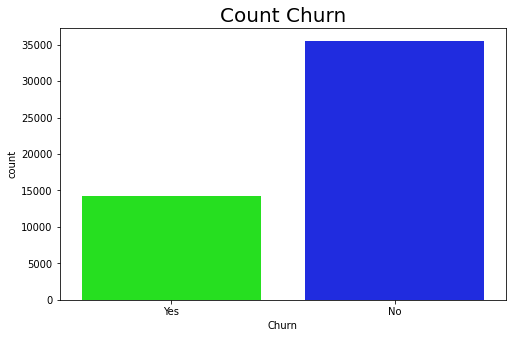

Not Churn 71.36798520662487 %
Churn 28.632014793375145 %


In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)
sns.countplot(df['Churn'], palette = 'hsv')
plt.title('Count Churn', fontsize = 20)
plt.show()
c=df['Churn'].value_counts()
t0 = c[0]/df.shape[0]
t1 = c[1]/df.shape[0]
print("Not Churn", t0*100,"%")
print("Churn", t1*100,"%")

In [ ]:
# Counting all the categorical variables to identify churn behaviour
cat_cols = ['ServiceArea', 'ChildrenInHH',	'HandsetRefurbished',	'HandsetWebCapable',	'TruckOwner',	'RVOwner',	'Homeownership',	'BuysViaMailOrder',	'RespondsToMailOffers',  'OptOutMailings',	'NonUSTravel',	'OwnsComputer',	'HasCreditCard', 'OwnsMotorcycle','NewCellphoneUser','NotNewCellphoneUser', 'MadeCallToRetentionTeam',	'CreditRating',	'PrizmCode',	'Occupation','MaritalStatus']

for col in cat_cols:
  print(df.groupby(col)['Churn'].value_counts(sort=True))
  print("======================================")


ServiceArea  Churn
AIRAIK803    No        3
             Yes       1
AIRAND864    Yes      11
             No       10
AIRASH828    No       26
                      ..
VAHRAD540    Yes       2
VAHROA540    Yes       6
             No        5
VAHSTA540    Yes       1
VAHWAY540    No        1
Name: Churn, Length: 1325, dtype: int64
ChildrenInHH  Churn
No            No       26843
              Yes      10640
Yes           No        8664
              Yes       3605
Name: Churn, dtype: int64
HandsetRefurbished  Churn
No                  No       30816
                    Yes      12036
Yes                 No        4691
                    Yes       2209
Name: Churn, dtype: int64
HandsetWebCapable  Churn
No                 No        3043
                   Yes       1804
Yes                No       32464
                   Yes      12441
Name: Churn, dtype: int64
TruckOwner  Churn
No          No       28704
            Yes      11576
Yes         No        6803
            Yes       2669

In [ ]:
# Converting imporant columns into binary

dict = {"No":0,"Yes":1}
convert_cat_cols = ['Churn','ChildrenInHH',	'HandsetRefurbished',	'HandsetWebCapable',	
                    'TruckOwner','OptOutMailings','OwnsComputer',  'HasCreditCard','NotNewCellphoneUser', 'OwnsMotorcycle']

for col in convert_cat_cols:
  df[col] = df[col].map(dict)


# Deleting unimportant columns
del_cols= ['CustomerID','ServiceArea', 'RVOwner',	'Homeownership',	'BuysViaMailOrder',	'RespondsToMailOffers', 'NonUSTravel',
            'NewCellphoneUser', 'MadeCallToRetentionTeam',	'CreditRating',	'PrizmCode',	'Occupation','MaritalStatus','HandsetPrice']
df = drop_useless_columns(df, del_cols)
df.head(2)

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,OptOutMailings,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating
0,NaN,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,2.0,2.0,361.0,62.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,0,4,NaN,0
1,NaN,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,2.0,1.0,1504.0,40.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,5,NaN,0


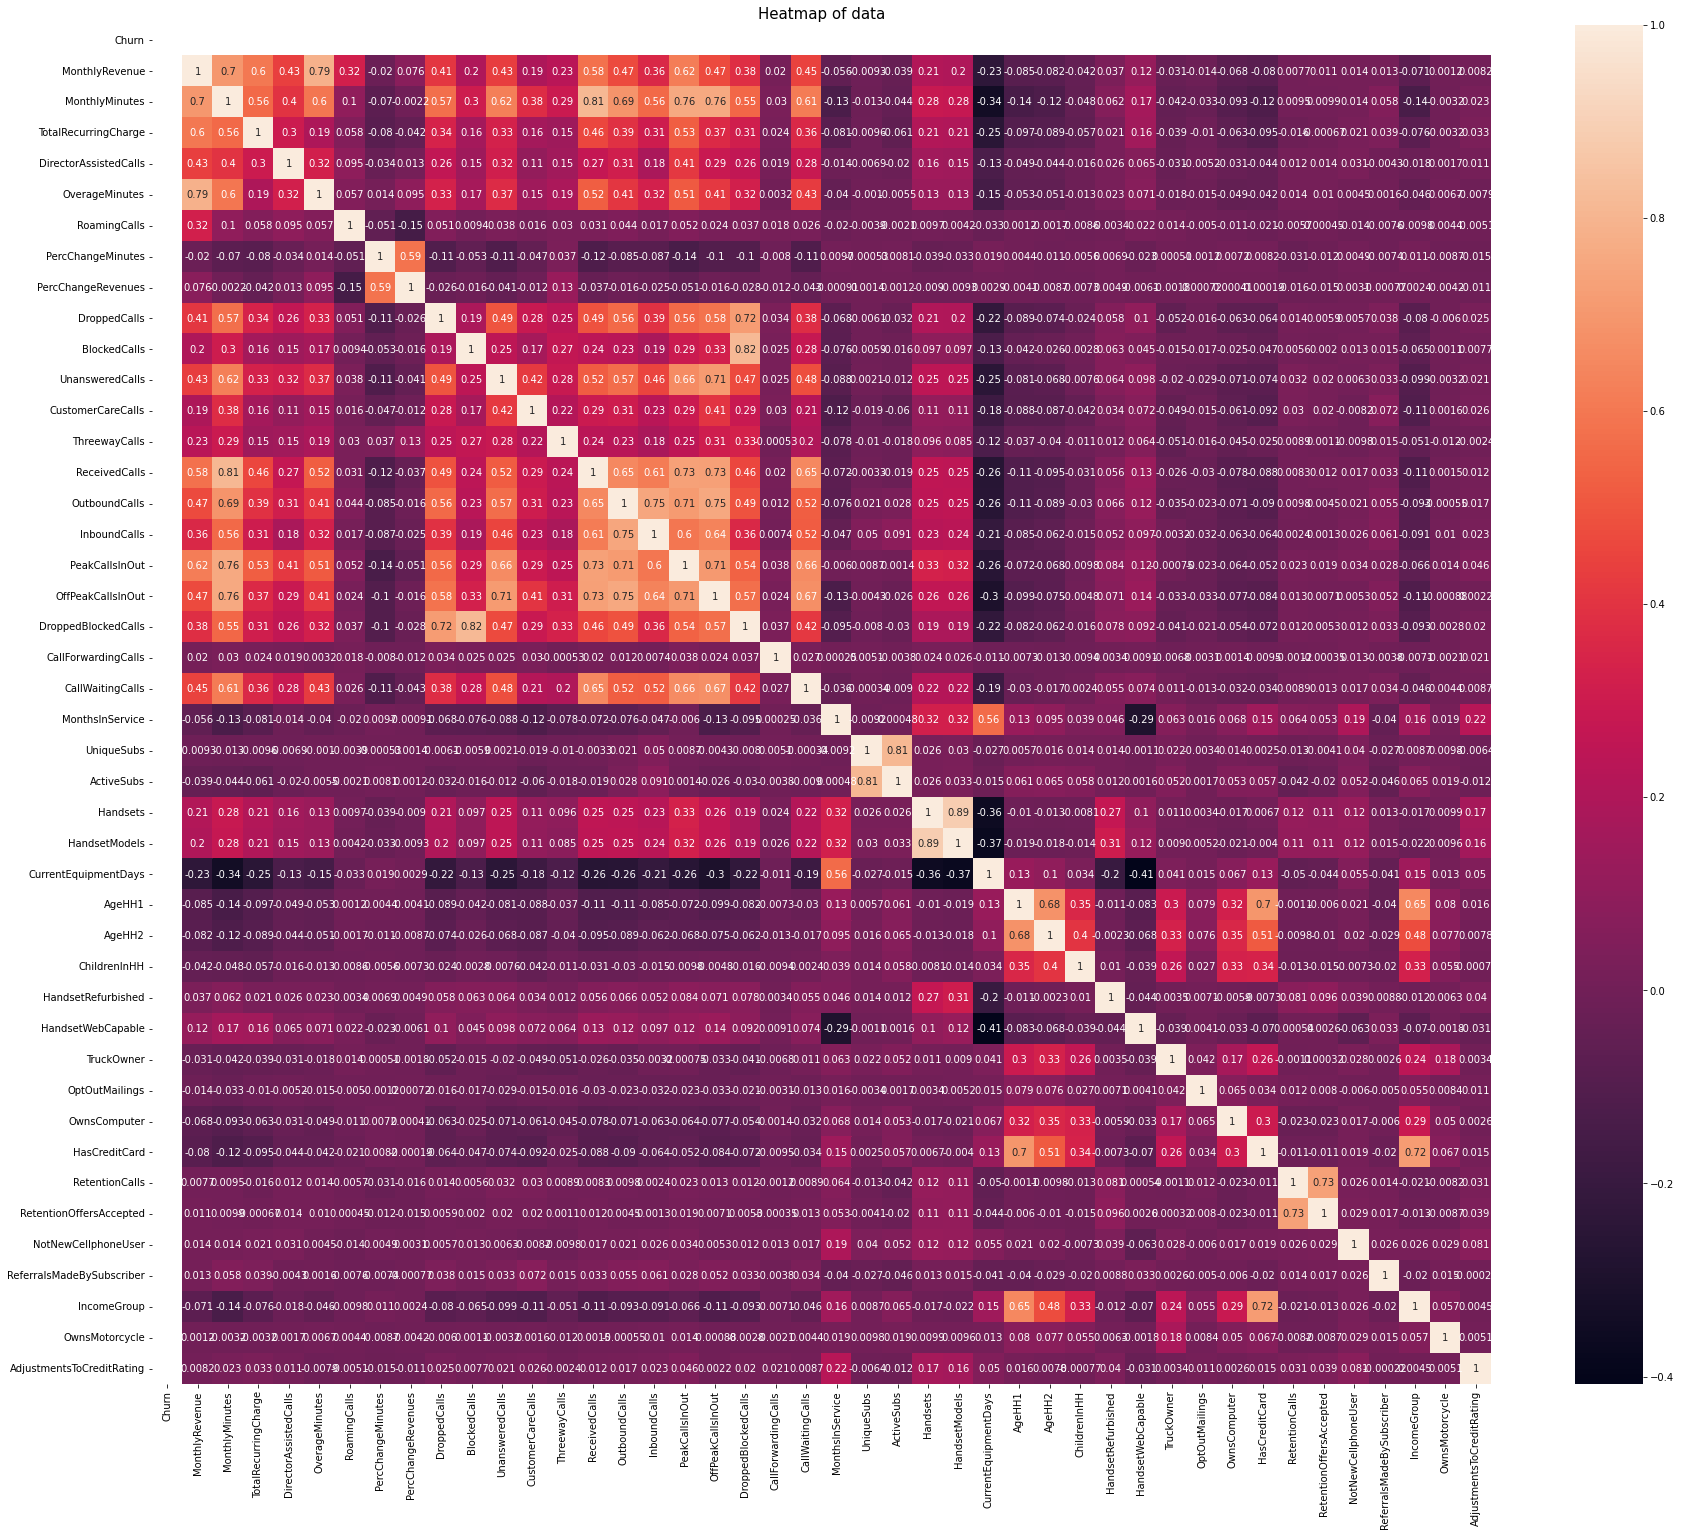

In [ ]:
# Making correlation map with respect to customers who Churn
churn_0 = df.loc[df['Churn'] == 0]
churn_1 = df.loc[df['Churn'] == 1]

plt.rcParams["figure.figsize"] = (30,25)
sns.heatmap(churn_1.corr(),annot = True)
plt.title("Heatmap of data",fontsize= 15)
plt.show()

In [ ]:
# Reduced number of columns from heatmap correlation information
#  Checking the relationship of columns with target column
corr_cols=[ 'Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge','DirectorAssistedCalls', 'OverageMinutes', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls','ReceivedCalls', 'OutboundCalls', 'PeakCallsInOut', 'DroppedBlockedCalls', 'AgeHH1','TruckOwner', 'OwnsComputer', 'HasCreditCard','IncomeGroup']
df2= df[corr_cols]
sns.pairplot(df2)

Output hidden; open in https://colab.research.google.com to view.

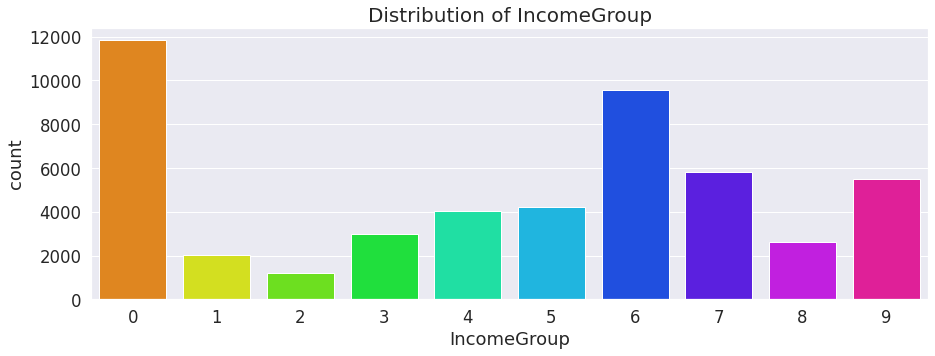

In [ ]:
#Showing Income Group Distribution
plt.rcParams['figure.figsize'] = (15, 5)
sns.countplot(df['IncomeGroup'], palette = 'hsv')
plt.title('Distribution of Income Group', fontsize = 20)
plt.show()

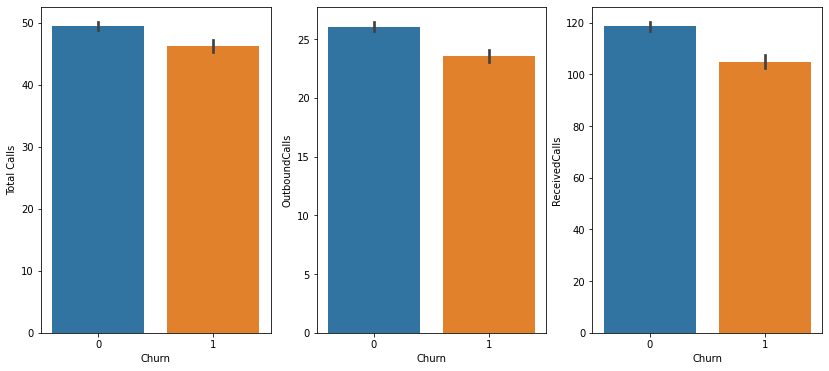

In [ ]:
df2["Total Calls"] = df2['DroppedCalls']  + df2['BlockedCalls'] + df2['UnansweredCalls'] + df2['DroppedBlockedCalls']
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(14,6))
s = sns.barplot(ax = ax1, x="Churn", y="Total Calls", data=df2)
s = sns.barplot(ax = ax2, x="Churn", y="OutboundCalls", data=df2)
s = sns.barplot(ax = ax3, x="Churn", y="ReceivedCalls", data=df2)
plt.show();

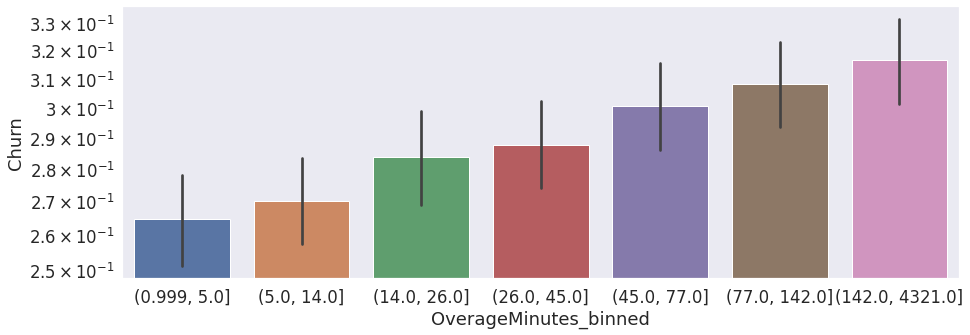

In [ ]:
bar_plot(df,"OverageMinutes", cut=7, logscale=True, drop_zero=True)

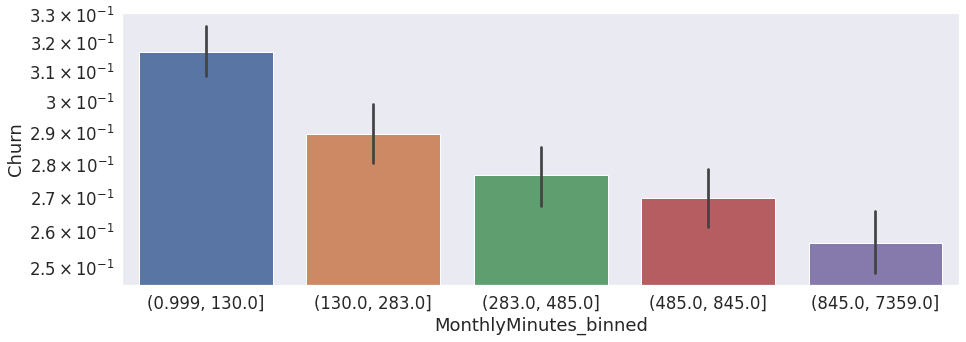

In [ ]:
# Use defined Barplot function plot the distribution of MonthlyMinutes
bar_plot(df, "MonthlyMinutes", cut=5, logscale=True, drop_zero=True)
# 


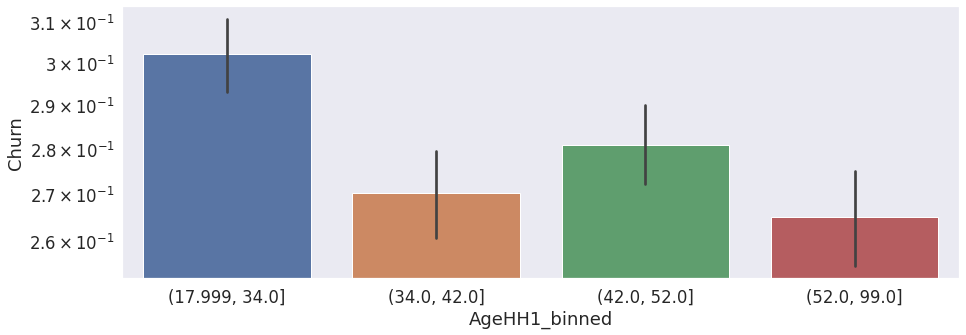

In [ ]:
bar_plot(df, "AgeHH1", cut=4, logscale=True, drop_zero=True)

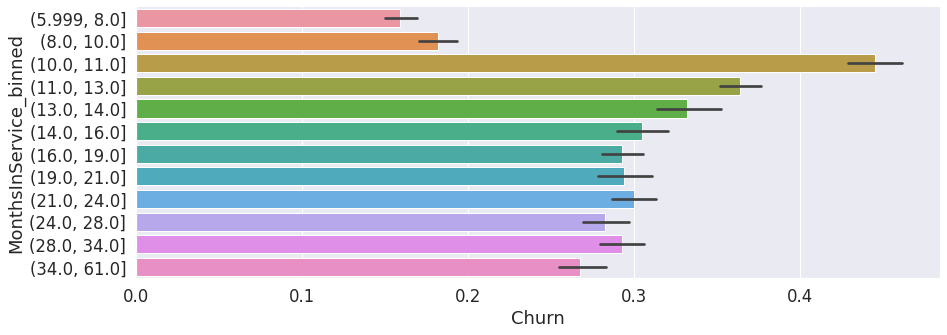

In [ ]:
cat_plot(df, "MonthsInService", cut=12)

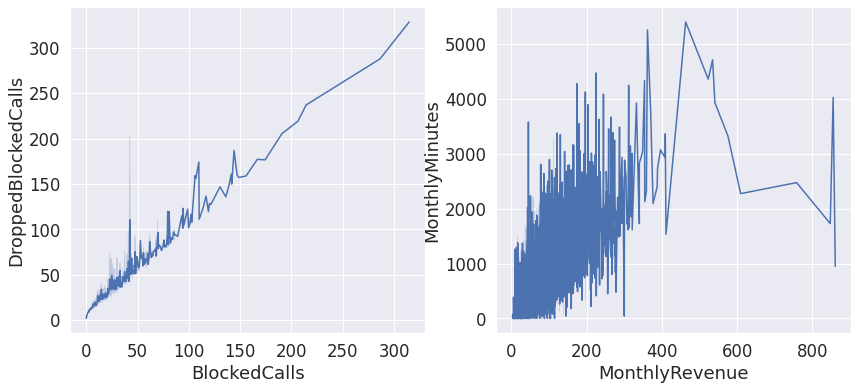

In [ ]:
Churn = df.loc[df['Churn'] == 1]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
s = sns.lineplot(ax = ax1, x="BlockedCalls", y="DroppedBlockedCalls", data=Churn)
s = sns.lineplot(ax = ax2, x="MonthlyRevenue", y="MonthlyMinutes", data=Churn)
plt.show();

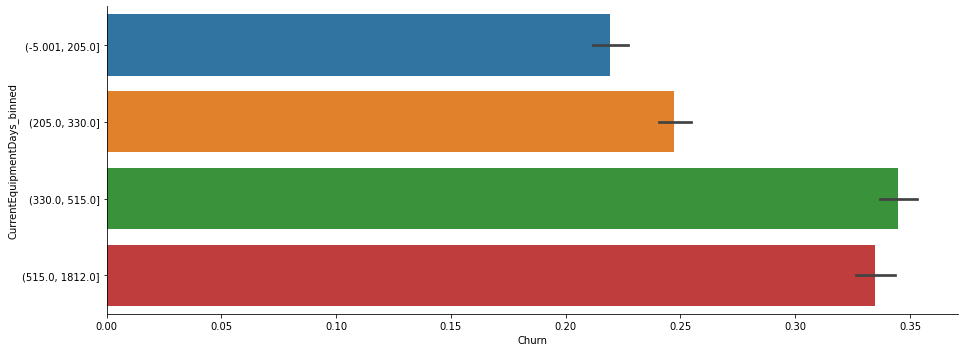

In [ ]:
# CurrentEquipmentDays
cat_plot(df, "CurrentEquipmentDays", cut=4)

## **ML Algorithms**

### Evaluation Metrics

In [ ]:
# Validation metrics for classification
def validationmetrics(model, testX, testY, verbose=True):   
    predictions = model.predict(testX)
    
    if model.__class__.__module__.startswith('lightgbm'):
        for i in range(0, predictions.shape[0]):
            predictions[i]= 1 if predictions[i] >= 0.5 else 0
    
    #Accuracy
    accuracy = accuracy_score(testY, predictions)*100
    
    #Precision
    precision = precision_score(testY, predictions, pos_label=1, labels=[0,1])*100
    
    #Recall
    recall = recall_score(testY, predictions,pos_label=1,labels=[0,1])*100
    
    #get FPR (specificity) and TPR (sensitivity)
    fpr , tpr, _ = roc_curve(testY, predictions)
    
    #AUC
    auc_val = auc(fpr, tpr)
    
    #F-Score
    f_score = f1_score(testY, predictions)
    
    if verbose:
        print("Prediction Vector: \n", predictions)
        print("\n Accuracy: \n", accuracy)
        print("\n Precision of event Happening: \n", precision)
        print("\n Recall of event Happening: \n", recall)
        print("\n AUC: \n",auc_val)
        print("\n F-Score:\n", f_score)
        #confusion Matrix
        print("\n Confusion Matrix: \n", confusion_matrix(testY, predictions,labels=[0,1]))
    
    res_map = {
                "model_obj": model,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "auc_val": auc_val,
                "f_score": f_score
              }
    return res_map


#Validation metrics for Regression algorithms
def validationmetrics_reg(model,testX,testY, verbose=True):
    predictions = model.predict(testX)
    
    # R-squared
    r2 = r2_score(testY,predictions)
    
    # Adjusted R-squared
    r2_adjusted = 1-(1-r2)*(testX.shape[0]-1)/(testX.shape[0]-testX.shape[1]-1)
    
    # MSE
    mse = mean_squared_error(testY,predictions)
    
    #RMSE
    rmse = math.sqrt(mse)
    
    if verbose:
        print("R-Squared Value: ", r2)
        print("Adjusted R-Squared: ", r2_adjusted)
        print("RMSE: ", rmse)
    
    res_map = {
                "model_obj": model,
                "r2": r2,
                "r2_adjusted": r2_adjusted,
                "rmse": rmse
              }
    return res_map

### Classification Algorithms

In [ ]:
# Classification Algorithms

def LogReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LogisticRegression()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def KNN(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = KNeighborsClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def GradientBoosting(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def AdaBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def SVM(trainX, testX, trainY, testY, svmtype="SVC", verbose=True, clf=None):
    # for one vs all
    if not clf:
        if svmtype == "Linear":
            clf = svm.LinearSVC()
        else:
            clf = svm.SVC()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def DecisionTree(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def RandomForest(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = RandomForestClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def NaiveBayes(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GaussianNB()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def XgBoost(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = XGBClassifier(random_state=1,learning_rate=0.01)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

def LightGbm(trainX, testX, trainY, testY, verbose=True, clf=None):
    d_train = lgb.Dataset(trainX, label=trainY)
    params = {}
    params['learning_rate'] = 0.003
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = 10
    params['min_data'] = 50
    params['max_depth'] = 10
    clf = lgb.train(params, d_train, 100)
    return validationmetrics(clf,testX,testY,verbose=verbose)


### Regression Algorithms

In [ ]:
# Regression Algorithms
    
def LinearReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf  = LinearRegression()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def RandomForestReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = RandomForestRegressor(n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def PolynomialReg(trainX, testX, trainY, testY, degree=3, verbose=True, clf=None):
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(trainX)
    poly.fit(X_poly, trainY)
    if not clf:
        clf = LinearRegression() 
    clf.fit(X_poly, trainY)
    return validationmetrics_reg(clf, poly.fit_transform(testX), testY, verbose=verbose)

def SupportVectorRegression(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = SVR(kernel="rbf")
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def DecisionTreeReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = DecisionTreeRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def GradientBoostingReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = GradientBoostingRegressor()
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def AdaBooostReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    if not clf:
        clf = AdaBoostRegressor(random_state=0, n_estimators=100)
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)

def VotingReg(trainX, testX, trainY, testY, verbose=True, clf=None):
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100)
    # sv = SVR(kernel="rbf")
    dt = DecisionTreeRegressor()
    # gb = GradientBoostingRegressor()
    ab = AdaBoostRegressor(random_state=0, n_estimators=100)
    if not clf:
        clf = VotingRegressor([('rf', rf), ('dt', dt), ('ab', ab)])
    clf.fit(trainX , trainY)
    return validationmetrics_reg(clf, testX, testY, verbose=verbose)


### Helper Functions

In [ ]:
# Helper function to run all algorithms provided in algo_list over given dataframe, without cross validation

# Helper function to provide list of supported algorithms for Classification
def get_supported_algorithms():
    covered_algorithms = [LogReg, KNN, GradientBoosting, AdaBoost,
                          SVM, DecisionTree, RandomForest, NaiveBayes,
                          XgBoost] #LightGbm
    return covered_algorithms
    
# Helper function to provide list of supported algorithms for Regression
def get_supported_algorithms_reg():
    covered_algorithms = [LinearReg, RandomForestReg, SupportVectorRegression,
                          DecisionTreeReg, GradientBoostingReg, AdaBooostReg, VotingReg]
    return covered_algorithms

# Helper function to scale Amount and Time as these are the inly two variable which were not scaled.
def get_scaled_df(df):
  rob_sc = RobustScaler()
  scaled_amount = rob_sc.fit_transform(df)
  
  return df

# By default it will run all supported algorithms 
def run_algorithms(df, label_col, algo_list, feature_list=[]):
    """
    Run Algorithms with manual split
    
    """
    # Lets make a copy of dataframe and work on that to be on safe side 
    _df = df.copy()
    
    if feature_list:
        impftrs = feature_list
        impftrs.append(label_col)
        _df = _df[impftrs]
    
    _df, trainX, testX, trainY, testY = traintestsplit(_df, 0.2, 91, label_col=label_col)
    algo_model_map = {}
    for algo in algo_list:
        print("============ " + algo.__name__ + " ===========")
        res = algo(trainX, testX, trainY, testY)
        algo_model_map[algo.__name__] = res.get("model_obj", None)
        print ("============================== \n")
    
    return algo_model_map
        


#Train Test Split: splitting manually
def traintestsplit(df,split,random=None, label_col=''):
    #make a copy of the label column and store in y
    y = df[label_col].copy()
    
    #now delete the original
    X = df.drop(label_col,axis=1)
    
    #manual split
    trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
    return X, trainX, testX, trainY, testY

#helper function which only splits into X and y
def XYsplit(df, label_col):
    y = df[label_col].copy()
    X = df.drop(label_col,axis=1)
    return X,y



# With stratified kfold validation support
def run_algorithms_cv(df, label_col, algo_list, feature_list=[], cross_valid_method=None):
    """
    Run Algorithms with cross validation
    
    """
    _df = df.copy()
    X,y = XYsplit(_df, label_col)
    
    # Select features if specified by driver program
    if feature_list:
        X = X[feature_list]
   
    result = {}
    algo_model_map = {}
    for algo in algo_list:
        clf = None
        result[algo.__name__] = {}
        # for trainX,trainY,testX,testY  in cross_valid_method(X, y, split=10):
        for train_index, test_index in cross_valid_method.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            res_algo = algo(X_train, X_test, y_train, y_test, verbose=False, clf=clf)
            # Get trained model so we could use it again in the next iteration
            clf = res_algo.get("model_obj", None)
            
            for k,v in res_algo.items():
                if k == "model_obj":
                    continue
                if k not in result[algo.__name__].keys():
                    result[algo.__name__][k] = list()
                result[algo.__name__][k].append(v)
                
        algo_model_map[algo.__name__] = clf
            
    score_map = {}
    # let take average scores for all folds now
    for algo, metrics in result.items():
        print("============ " + algo + " ===========")
        score_map[algo] = {}
        for metric_name, score_lst in metrics.items():
            score_map[algo][metric_name] = np.mean(score_lst)
        print(score_map[algo])
        print ("============================== \n")
        score_map[algo]["model_obj"] = algo_model_map[algo]
    
    return score_map


# Helper function to get fetaure importance metrics via Random Forest Feature Selection (RFFS)
def RFfeatureimportance(df, trainX, testX, trainY, testY, trees=35, random=None, regression=None):
    if regression:
        clf  = RandomForestRegressor(n_estimators=trees, random_state=random)
    else:
        clf  = RandomForestClassifier(n_estimators=trees, random_state=random)
    clf.fit(trainX,trainY)
    #validationmetrics(clf,testX,testY)
    res = pd.Series(clf.feature_importances_, index=df.columns.values).sort_values(ascending=False)*100
    print("Random Fores Feature Selections List: ", res)
    return res


# Helper function to select important features via RFFS, run supported ML algorithms over dataset with manual split and measure accuracy without Cross Validation - select features with importance >=threshold
def MachineLearningwithRFFS(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    df_cpy, trainX, testX, trainY, testY = traintestsplit(df_cpy, 0.2, 91, label_col=label_col)
    res = RFfeatureimportance(df_cpy, trainX, testX, trainY, testY, trees=10, regression=regression)
    
    impftrs = list(res[res > threshold].keys())
    #impftrs.append(label_col)
    
    print ("Selected Features =" + str(impftrs))
    # print(df.shape)
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=impftrs)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via RFFS, run supported ML algorithms over dataset with cross validation and measure accuracy --- select features with importance >=threshold
def MachineLearningwithRFFS_CV(df, label_col, threshold, algo_list, regression):
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    df_cpy.astype(float)
    # df_cpy = get_scaled_df(df_cpy)
    df_cpy, trainX, testX, trainY, testY = traintestsplit(df_cpy, 0.2, 91, label_col=label_col)

    # First we need to normalize the data
    # sc = StandardScaler()
    # trainX = sc.fit_transform(trainX)
    # testX = sc.transform(testX)

    res = RFfeatureimportance(df_cpy, trainX, testX, trainY, testY,
                              trees=10, regression=regression)

    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    # print(df.shape)
    cross_valid_method=None
    if regression:
      cross_valid_method = cross_valid_kfold(n_splits=10, random_state=None, shuffle=False)
    else:
      cross_valid_method = cross_valid_stratified_kf(n_splits=10, random_state=None, shuffle=False)

    results = run_algorithms_cv(df, label_col, algo_list, feature_list=impftrs, cross_valid_method=cross_valid_method)
    return {"Selected_features": impftrs, "Results": results}
    


# ## Mutual Information Feature Selection (MIFS)
# 
# MachineLearningwithMIFS() => Helper function to select important features and run supported ML algorithms over dataset

# mutualinformation()  => Helper function to get fetaure importance metrics via Mutual Information Classifier/Regressor.
def mutualinformation(df, label_col, regression=False):
    df_cpy = df.copy()
    y = df_cpy[label_col].copy()
    X = df_cpy.drop(label_col,axis=1)
    if regression:
        mutual_info = mutual_info_regression(X,y,random_state=35)
    else:
        mutual_info = mutual_info_classif(X,y,random_state=35)
    results = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)*100
    print(results)
    return results



# Helper function to select important features via MIFS, run supported ML algorithms over dataset with manual split and measure accuracy, without CV ... select features with importance >=threshold
def MachineLearningwithMIFS(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    res = mutualinformation(df_cpy, label_col=label_col, regression=regression)
    
    #include all selected features in impftrs
    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=impftrs)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via MIFS, run supported ML algorithms over dataset with manual split and measure accuracy, with CV ... select features with importance >=threshold
def MachineLearningwithMIFS_CV(df, label_col, threshold=5, algo_list=get_supported_algorithms(), regression=False):
    
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    res = mutualinformation(df_cpy, label_col=label_col, regression=regression)
    
    #include all selected features in impftrs
    impftrs = list(res[res > threshold].keys())
    
    print ("Selected Features =" + str(impftrs))
    cross_valid_method=None
    if regression:
        cross_valid_method = cross_valid_kfold
    else:
        cross_valid_method = cross_valid_stratified_kf
    results = run_algorithms_cv(df, label_col, algo_list=algo_list, feature_list=impftrs, cross_valid_method=cross_valid_method)
    return {"selected_features": impftrs, "results": results}


# Helper function to select important features via REFS, run supported ML algorithms over dataset with manual split and measure accuracy, without CV ... select features with importance >=threshold
# flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features
def GenericREFS(df, label_col,
                algo_list=get_supported_algorithms(),
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    
    results = run_algorithms(df, label_col, algo_list=algo_list, feature_list=feature_list)
    return {"selected_features": feature_list, "results": results}


# Helper function to select important features via REFS, run supported ML algorithms over dataset with manual split and measure accuracy, with CV ... select features with importance >=threshold
# flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features
def GenericREFS_CV(df, label_col,
                algo_list=get_supported_algorithms(),
                regression=False,
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFECV(estimator=clf, step=1, cv=10)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    cross_valid_method= None
    if regression:
        cross_valid_method = cross_valid_kfold
    else:
        cross_valid_method = cross_valid_stratified_kf
    results = run_algorithms_cv(df, label_col, algo_list=algo_list, feature_list=feature_list, cross_valid_method=cross_valid_method)
    return {"selected_features": feature_list, "results": results}

# Helper function to provide list of classification algorithms to be used for recursive elimination feature selection
def get_supported_algorithms_refs():
    algo_list = [LogisticRegression, GradientBoostingClassifier, AdaBoostClassifier,
                          DecisionTreeClassifier, RandomForestClassifier]
    return algo_list

# Helper function to provide list of regression algorithms to be used for recursive elimination feature selection
def get_supported_reg_algorithms_refs():
    algo_list = [LinearRegression, RandomForestRegressor,
                 DecisionTreeRegressor, GradientBoostingRegressor, AdaBoostRegressor]
    return algo_list


# Helper function to perform feature selection using PCA. It runs supported algorithms with over specified components and mesure performance stats, without Cross Validation

def PCA_FS(df, label_col, n_components, algo_list=get_supported_algorithms()):
    df_cpy = df.copy()
    X,y = XYsplit(df_cpy, label_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # First we need to normalize the data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Now perform PCA
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    algo_model_map = {}
    # At this stage we apply alogorithms
    for algo in algo_list:
        print("============ " + algo.__name__ + " ===========")
        res = algo(X_train, X_test, y_train, y_test)
        algo_model_map[algo.__name__] = res.get("model_obj", None)
        
        print("============================== \n")
    return {"n_components": n_components, "results": algo_model_map}


# Helper function to perform feature selection using PCA. It runs supported algorithms with over specified components and mesure performance stats, with Cross Validation

def PCA_FS_CV(df, label_col, n_components, algo_list, regression):
  
  df_cpy = df.copy()
  # First we need to normalize the data
  X,y = XYsplit(df_cpy, label_col)

# cross_valid_method = cross_valid_stratified_kf(n_splits=10) #if regression else cross_valid_stratified_kf 
  result = {}
  algo_model_map = {}

  if regression:
    cross_valid_method = cross_valid_kfold(n_splits=10, random_state=None, shuffle=False)
  else:
    cross_valid_method = cross_valid_stratified_kf(n_splits=10, random_state=None, shuffle=False)

  for train_index, test_index in cross_valid_method.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # First we need to normalize the data
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  for algo in algo_list:
    clf = None
    result[algo.__name__] = {} 
            
    # Now perform PCA
    pca = PCA(n_components=7)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
            
    # apply algo on this fold and save result for later usage
    res_algo = algo(X_train, X_test, y_train, y_test, verbose=False, clf=clf)
    # Get trained model so we could use it again in the next iteration
    clf = res_algo.get("model_obj", None)
            
    for k,v in res_algo.items():
      if k == "model_obj":
        continue
      if k not in result[algo.__name__].keys():
        result[algo.__name__][k] = list()
        result[algo.__name__][k].append(v)
            
    algo_model_map[algo.__name__] = clf
        
  score_map = {}
    
  # let take average scores for all folds now
  for algo, metrics in result.items():
    print("============ " + algo + " ===========")
    score_map[algo] = {}
    for metric_name, score_lst in metrics.items():
      score_map[algo][metric_name] = np.mean(score_lst)
      # print(score_map[algo])
      # print ("============================== \n")
      score_map[algo]["model_obj"] =  algo_model_map[algo]
    print(score_map[algo])
    print ("============================== \n")
  print("n_components", n_components, "results", algo_model_map)


## **Applying Classification**
>To apply classifcation algorithms, first I have used dimension reduction technique: PCA, and reduced features to 7 most important components then called classfication methods. Decision Tree has given best performance which is evaluated by accuracy, precision, recall and f1-score metrics.
While SVM and Naive Bayes has given worst performance.

>Similarly, I used feature selection technique i.e. Random Forest, then called classification methods.Here, I have set the threshold to 3(ranking), which means below the threshold features will not be selected.
Here, again Decision Tree is superior in terms of performance among all the algorithms keeping a right balance between precision and recall.

In [ ]:
##### PCA #####
algo_list = get_supported_algorithms()
target_label = "Churn"
n_components =7
regression= False

PCA_FS_CV(df2, target_label, n_components, algo_list, regression)

============ LogReg ===========
{'accuracy': 71.39698492462313, 'model_obj': LogisticRegression(), 'precision': 100.0, 'recall': 0.0702247191011236, 'auc_val': 0.5003511235955056, 'f_score': 0.0014035087719298247}

============ KNN ===========
{'accuracy': 65.7286432160804, 'model_obj': KNeighborsClassifier(), 'precision': 29.667149059334296, 'recall': 14.396067415730338, 'auc_val': 0.5035489093118254, 'f_score': 0.1938534278959811}

============ GradientBoosting ===========
{'accuracy': 71.51758793969849, 'model_obj': GradientBoostingClassifier(), 'precision': 70.58823529411765, 'recall': 0.8426966292134831, 'auc_val': 0.5035094561114293, 'f_score': 0.016655100624566273}

============ AdaBoost ===========
{'accuracy': 71.51758793969849, 'model_obj': AdaBoostClassifier(n_estimators=100, random_state=0), 'precision': 76.92307692307693, 'recall': 0.7022471910112359, 'auc_val': 0.5030888197342733, 'f_score': 0.013917884481558802}

============ SVM ===========
{'accuracy': 71.3567839195979

In [ ]:
#### RFS ####
algo_list = [LogReg, AdaBoost, SVM, DecisionTree, RandomForest, XgBoost]
target_label = "Churn"
threshold=3
regression=False

MachineLearningwithRFFS_CV(df, target_label, threshold, algo_list, regression)

Random Fores Feature Selections List:  CurrentEquipmentDays         6.735897
PercChangeMinutes            5.775367
MonthlyMinutes               5.349819
MonthlyRevenue               5.076845
PercChangeRevenues           4.939141
MonthsInService              4.607945
OffPeakCallsInOut            4.470113
ReceivedCalls                4.204041
UnansweredCalls              4.188989
PeakCallsInOut               4.186300
OutboundCalls                3.859771
DroppedBlockedCalls          3.436300
TotalRecurringCharge         3.378757
DroppedCalls                 3.302279
InboundCalls                 3.134323
AgeHH1                       3.117673
OverageMinutes               3.039875
BlockedCalls                 2.937508
AgeHH2                       2.488146
IncomeGroup                  2.457455
DirectorAssistedCalls        2.266349
RoamingCalls                 2.182722
CustomerCareCalls            2.076779
CallWaitingCalls             1.894056
UniqueSubs                   1.394531
ThreewayCal

{'Results': {'AdaBoost': {'accuracy': 69.83431991145437,
   'auc_val': 0.5140633593551505,
   'f_score': 0.12998968026202354,
   'model_obj': AdaBoostClassifier(n_estimators=100, random_state=0),
   'precision': 44.1144415955395,
   'recall': 8.284535777646362},
  'DecisionTree': {'accuracy': 59.29606311299263,
   'auc_val': 0.5200344701507467,
   'f_score': 0.3300476772044214,
   'model_obj': DecisionTreeClassifier(),
   'precision': 31.850436227444145,
   'recall': 34.938764044943824},
  'LogReg': {'accuracy': 71.14889035208196,
   'auc_val': 0.5004620973098688,
   'f_score': 0.013020837183829074,
   'model_obj': LogisticRegression(),
   'precision': 34.16972681291436,
   'recall': 0.6669475655430711},
  'RandomForest': {'accuracy': 68.62828127777149,
   'auc_val': 0.5098387972470537,
   'f_score': 0.14644477867024322,
   'model_obj': RandomForestClassifier(),
   'precision': 44.429033983716465,
   'recall': 9.6954021289178},
  'SVM': {'accuracy': 71.35994522451486,
   'auc_val': 0.4

## **Applying Regression** 
>To apply regression algorithms, first I have used dimension reduction technique: PCA, and reduced features to 7 most important components then called regression methods. Here error scores are calculated to evaluate the performance. 

> Since, majority of the column containing multiclass variables that is why regression alogrithms could not perform well here.

>Similarly, used feature selection technique i.e. Random Forest, then called regression methods. Here, again I have set the threshold to 3(ranking).

> In both techiniques, Random Forest and Ada boost has given similar performance.

In [ ]:
#### PCA #####
algo_list = [RandomForestReg,DecisionTreeReg, GradientBoostingReg, AdaBooostReg]
target_label = "Churn"
n_components =7
regression= True

PCA_FS_CV(df, target_label, n_components, algo_list, regression)

============ RandomForestReg ===========
{'r2': -0.09066564342134442, 'model_obj': RandomForestRegressor(), 'r2_adjusted': -0.09220272002773644, 'rmse': 0.4021847871502295}

============ DecisionTreeReg ===========
{'r2': -1.3000067562523938, 'model_obj': DecisionTreeRegressor(), 'r2_adjusted': -1.3032481589690774, 'rmse': 0.5840424022604789}

============ GradientBoostingReg ===========
{'r2': -0.03865192408424889, 'model_obj': GradientBoostingRegressor(), 'r2_adjusted': -0.04011569768372336, 'rmse': 0.3924775661676618}

============ AdaBooostReg ===========
{'r2': -0.0560155700169338, 'model_obj': AdaBoostRegressor(n_estimators=100, random_state=0), 'r2_adjusted': -0.057503814226742334, 'rmse': 0.3957445871983138}

n_components 7 results {'RandomForestReg': RandomForestRegressor(), 'DecisionTreeReg': DecisionTreeRegressor(), 'GradientBoostingReg': GradientBoostingRegressor(), 'AdaBooostReg': AdaBoostRegressor(n_estimators=100, random_state=0)}


In [ ]:
#### RFS ####
algo_list = [RandomForestReg,DecisionTreeReg, GradientBoostingReg, AdaBooostReg]
target_label = "Churn"
threshold=3
regression=True

MachineLearningwithRFFS_CV(df, target_label, threshold, algo_list, regression)

Random Fores Feature Selections List:  CurrentEquipmentDays         8.161097
PercChangeMinutes            6.879642
MonthlyMinutes               6.488634
PercChangeRevenues           5.351625
MonthlyRevenue               5.267463
UnansweredCalls              4.243962
MonthsInService              4.169336
PeakCallsInOut               4.043708
ReceivedCalls                3.999828
OffPeakCallsInOut            3.975714
OutboundCalls                3.708534
AgeHH1                       3.104361
TotalRecurringCharge         3.090239
InboundCalls                 3.058932
DroppedBlockedCalls          2.966568
DroppedCalls                 2.942152
OverageMinutes               2.823568
BlockedCalls                 2.794432
DirectorAssistedCalls        2.369576
AgeHH2                       2.347191
RoamingCalls                 2.200043
IncomeGroup                  2.188253
CustomerCareCalls            2.156788
CallWaitingCalls             1.833270
UniqueSubs                   1.271342
ThreewayCal

{'Results': {'AdaBooostReg': {'model_obj': AdaBoostRegressor(n_estimators=100, random_state=0),
   'r2': 0.032521221644828124,
   'r2_adjusted': 0.02979054552500514,
   'rmse': 0.4421525760465217},
  'DecisionTreeReg': {'model_obj': DecisionTreeRegressor(),
   'r2': -0.8843647842308684,
   'r2_adjusted': -0.8896833399336694,
   'rmse': 0.6164818102877436},
  'GradientBoostingReg': {'model_obj': GradientBoostingRegressor(),
   'r2': 0.05489463995337894,
   'r2_adjusted': 0.05222711162840251,
   'rmse': 0.4369518151210922},
  'RandomForestReg': {'model_obj': RandomForestRegressor(),
   'r2': 0.02878342974877244,
   'r2_adjusted': 0.026042204096164902,
   'rmse': 0.44286112560075974}},
 'Selected_features': ['CurrentEquipmentDays',
  'PercChangeMinutes',
  'MonthlyMinutes',
  'PercChangeRevenues',
  'MonthlyRevenue',
  'UnansweredCalls',
  'MonthsInService',
  'PeakCallsInOut',
  'ReceivedCalls',
  'OffPeakCallsInOut',
  'OutboundCalls',
  'AgeHH1',
  'TotalRecurringCharge',
  'InboundCal